# Get dataset metrics

In [1]:
import nltk
import os
import pickle
import random
import string

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from nltk.corpus import stopwords
from pymystem3 import Mystem
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression as Logit
from sklearn.metrics import f1_score, roc_auc_score, plot_roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

In [2]:
# nltk.download('stopwords')

### Get data

In [3]:
# dataset = 'bbf'
dataset = 'ci'

In [4]:
data_path = '../results'

In [5]:
if dataset == 'bbf':
    with open(os.path.join(data_path, 'result_bbf.pickle'), 'rb') as f:
        df = pickle.load(f)
else:
    with open(os.path.join(data_path, 'result_ci.pickle'), 'rb') as f:
        df = pickle.load(f)

In [6]:
df.shape

(389447, 13)

In [7]:
df[df.target == 1].shape

(26925, 13)

### Inspect data

Length distributions of sarcastic and nonsarcastic texts.

In [8]:
len_list = [len(q) for q in df[df.target == 0]['quote']]
target_len_list = [len(q) for q in df[df.target == 1]['quote']]

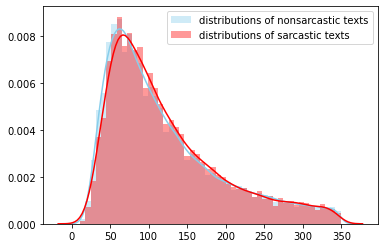

In [9]:
sns.distplot(len_list, color="skyblue", label="distributions of nonsarcastic texts")
sns.distplot(target_len_list, color="red", label="distributions of sarcastic texts")
plt.legend();

### Delete punctuation

In [10]:
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

In [11]:
df.quote = df.quote.apply(remove_punctuations)

In [12]:
df.quote = df.quote.apply(lambda s: s.lower() if type(s) == str else s)

In [13]:
df['quote'] = df['quote'].apply(lambda s: ' '.join(s.split()))

### Add mystem

In [14]:
mystem = Mystem()

In [15]:
words_to_del = [' ', '\n'] + stopwords.words("russian")

In [16]:
def stem_text(text):
    text_list = mystem.lemmatize(" ".join(text.split()))
    return " ".join(
        [elem for elem in text_list if elem not in words_to_del]
    )

In [17]:
df.quote = df.quote.apply(stem_text)

In [18]:
df = df[df['quote'].apply(lambda x: len(x) > 10)]

### Get the top 20 common words:

In [19]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2,2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [20]:
common_words = get_top_n_words(df.quote, 20)
for word, freq in common_words:
    print(word, '--', freq)

человек который -- 4744
друг друг -- 4393
самый дело -- 2419
весь жизнь -- 2205
свой жизнь -- 2025
жизнь это -- 1594
каждый день -- 1461
весь время -- 1445
весь это -- 1410
человек мочь -- 1405
любовь это -- 1308
знать это -- 1268
весь мир -- 1249
это значить -- 1244
человек это -- 1218
который мочь -- 1204
конец конец -- 1116
наш жизнь -- 1070
это самый -- 1062
это просто -- 1053


In [21]:
common_words = get_top_n_words(df[df.target == 1]['quote'], 20)
for word, freq in common_words:
    print(word, '--', freq)

человек который -- 253
друг друг -- 195
самый дело -- 125
весь время -- 123
весь жизнь -- 99
весь это -- 87
знать это -- 83
свой жизнь -- 80
выходить замуж -- 79
женщина который -- 76
хотеть сказать -- 75
каждый день -- 74
думать это -- 72
это значить -- 68
человек это -- 67
это просто -- 64
это самый -- 63
это твой -- 63
это очень -- 62
сей пора -- 61


### Split data to train and test

In [22]:
# get balanced data
# df = df.groupby(
#     'target', group_keys=False
# ).apply(lambda x: x.sample(n=26880)).sample(frac=1).reset_index(drop=True)

In [23]:
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

## Random

In [24]:
y_test = test_df.target
y_pred = [random.choice([0, 1]) for y in y_test]

In [25]:
f1_score(y_test, y_pred, average='binary')

0.12228969216628746

## Bag-of-Words

In [26]:
vectorizer = CountVectorizer(ngram_range=(1,1))
X = vectorizer.fit_transform(train_df.quote)
y = train_df.target

In [27]:
X_test = vectorizer.transform(test_df.quote)
y_test = test_df.target

In [28]:
normalize(X, copy=False)
normalize(X_test, copy=False)

<116553x76769 sparse matrix of type '<class 'numpy.float64'>'
	with 1173368 stored elements in Compressed Sparse Row format>

In [29]:
clf = Logit(
    solver='liblinear',
    class_weight={
        0: df[df.target == 0].shape[0], 
        1: df[df.target == 1].shape[0]
    },
    dual=True,
    fit_intercept=False,
    random_state=0
)

In [30]:
clf.fit(X, y)

/home/kate/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LogisticRegression(class_weight={0: 361609, 1: 26900}, dual=True,
                   fit_intercept=False, random_state=0, solver='liblinear')

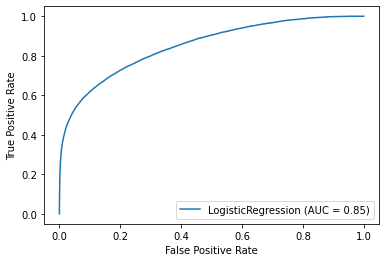

In [31]:
plot_roc_curve(clf, X, y);

In [32]:
f1_score(y, clf.predict(X), average='binary')

0.5015858776791722

In [33]:
y_pred = clf.predict(X_test)
f1_score(y_test, y_pred, average='binary')

0.1351550465474516

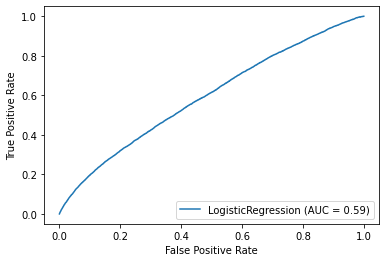

In [34]:
plot_roc_curve(clf, X_test, y_test);

## Bag-of-Bi-grams

In [35]:
vectorizer = CountVectorizer(ngram_range=(2,2))
X = vectorizer.fit_transform(train_df.quote)
y = train_df.target

In [36]:
X_test = vectorizer.transform(test_df.quote)
y_test = test_df.target

In [37]:
normalize(X, copy=False)
normalize(X_test, copy=False)

<116553x1582879 sparse matrix of type '<class 'numpy.float64'>'
	with 600653 stored elements in Compressed Sparse Row format>

In [38]:
clf = Logit(
    solver='liblinear',
    class_weight={
        0: df[df.target == 0].shape[0] / df.shape[0], 
        1: df[df.target == 1].shape[0] / df.shape[0]
    },
    dual=True,
    fit_intercept=False,
    random_state=0
)

In [39]:
clf.fit(X, y)

LogisticRegression(class_weight={0: 0.9307609347531203, 1: 0.06923906524687974},
                   dual=True, fit_intercept=False, random_state=0,
                   solver='liblinear')

In [40]:
f1_score(y, clf.predict(X), average='binary')

0.3088875915031212

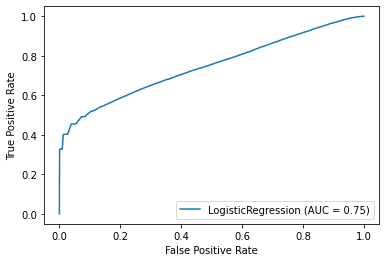

In [41]:
plot_roc_curve(clf, X, y);

In [42]:
y_pred = clf.predict(X_test)
f1_score(y_test, y_pred, average='binary')

0.01805665274799684

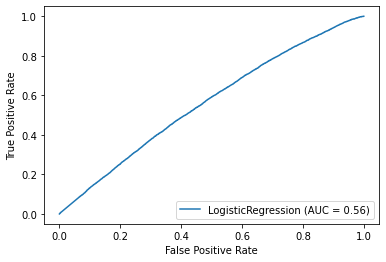

In [43]:
plot_roc_curve(clf, X_test, y_test);